## Extended kalman filter

In [1]:
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import numpy as np
from tqdm import tqdm

In [8]:
Ts=0.1 # Sampling period, fixed in the Thymio program

A = np.array([[1,0,0,0,0], [0,1,0,0,0], [0,0,1,0,0], [0,0,0,0,0], [0,0,0,0,0]])

# State covariance
# q_x=2.3
# q_y=7
# q_yaw=0.0019
# q_v = 8.34
# q_w = 0.0037

q_x = 73.75  # Variance in x (mm²)
q_y = 1551.06  # Variance in y (mm²)
q_yaw = 4.6  # Variance in yaw (rad²)
q_v = 0.34  # Variance in speed (mm²/s²)
q_w = 0.0001  # Variance in angular velocity (rad²/s²)

Q = np.array([[q_x,0,0,0,0],[0,q_y,0,0,0],[0,0,q_yaw,0,0],[0,0,0,q_v,0],[0,0,0,0,q_w]])

process_noise=np.random.multivariate_normal(mean=np.zeros(Q.shape[0]), cov=Q)

# Observation covariance
# [TODO] see to calculate the values of r_x,r_y,r_yaw from the camera (or try and error)
# r_x=1
# r_y=1
# r_yaw=1
# r_v = 8.34
# r_w = 0.0037

r_x=10000
r_y=10000
r_yaw=1000000
r_v = 243.89
r_w = 0.0037

R_cam = np.array([[r_x,0,0,0,0],[0,r_y,0,0,0],[0,0,r_yaw,0,0],[0,0,0,r_v,0],[0,0,0,0,r_w]])
# R_odometry=np.array([[np.inf,0,0,0,0],[0,np.inf,0,0,0],[0,0,np.inf,0,0],[0,0,0,r_v,0],[0,0,0,0,r_w]])
R_odometry=np.array([[r_v,0],[0,r_w]])

sensor_noise_cam=np.random.multivariate_normal(mean=np.zeros(R_cam.shape[0]), cov=R_cam)
sensor_noise_odo=np.random.multivariate_normal(mean=np.zeros(R_odometry.shape[0]), cov=R_odometry)

# H = np.eye(5)


In [9]:
def ekf(state_est_prev, control_vect_prev, P_prev, obs_camera, obs_odometry, camera_state):
    """
    Estimates the current state using input sensor data and the previous state
    
    param state_est_prev: previous state a posteriori estimation = [x, y, yaw, v, omega]
    param control_vect_prev: previous velocity vector = [v, omega]
    param P_prev: previous state a posteriori covariance
    # param obs_vect: observation vector = [x, y, yaw, v, omega]
    param obs_camera: observation vector = [x, y, yaw,]
    param obs_odometry: observation vector = [v, omega]
    param camera_state: boolean, True if camera available, False otherwise

    return state_est: new a posteriori state estimation
    return P_est: new a posteriori state covariance
    """
    # Predict the state estimate
    yaw=state_est_prev[2]
    B = np.array([[np.cos(yaw)*Ts,0],[np.sin(yaw)*Ts,0],[0, Ts],[1,0],[0,1]])

    # state_pred = A @ state_est_prev + B @ control_vect_prev + process_noise
    state_pred = A @ state_est_prev + B @ control_vect_prev 


    # Predict the state covariance P_pred
    v=control_vect_prev[0]
    # G=Jaccobian of A @ state_est_prev + B @ control_vect_prev
    G = np.array([[1,0,-np.sin(yaw)*Ts*v,np.cos(yaw)*Ts,0],[0,1,np.cos(yaw)*Ts*v, np.sin(yaw)*Ts,0],[0,0,1,0,Ts],[0,0,0,1,0],[0,0,0,0,1]]) 
    
    P_pred =  G @ P_prev @ G.T + Q


    # inovation / measurement residual    
    if camera_state:
        R = R_cam
        sensor_noise = sensor_noise_cam
        obs_vect=np.concatenate((obs_camera,obs_odometry))
        H=np.eye(5)
    else:
        R = R_odometry
        sensor_noise = sensor_noise_odo
        obs_vect=obs_odometry
        H=np.array([[0, 0, 0, 1, 0],
                      [0, 0, 0, 0, 1]])

    i = obs_vect - (H @ state_pred + sensor_noise)
    # measurement prediction covariance
    S = H @ P_pred @ H.T + R

    # Kalman gain
    K = P_pred @ H.T @ np.linalg.pinv(S)

    # Update state estimate
    state_est = state_pred + K @ i
    # Update covariance estimate
    P_est = P_pred - K @ H @ P_pred

    return state_est, P_est

## Test going forward

In [10]:
thymio_data_stock_straight=[{'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': -3, 'right_speed': 0}, {'left_speed': -4, 'right_speed': 0}, {'left_speed': -4, 'right_speed': 0}, {'left_speed': -9, 'right_speed': 0}, {'left_speed': -3, 'right_speed': 0}, {'left_speed': -4, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': -3, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': -3, 'right_speed': 0}, {'left_speed': -7, 'right_speed': 0}, {'left_speed': 1, 'right_speed': 0}, {'left_speed': -4, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': -5, 'right_speed': 0}, {'left_speed': -6, 'right_speed': 0}, {'left_speed': -5, 'right_speed': 0}, {'left_speed': -5, 'right_speed': 0}, {'left_speed': -3, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': -5, 'right_speed': 0}, {'left_speed': -5, 'right_speed': 0}, {'left_speed': -2, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': 0, 'right_speed': 0}, {'left_speed': -5, 'right_speed': 0}, {'left_speed': 1, 'right_speed': 0}, {'left_speed': -3, 'right_speed': 0}, {'left_speed': 29, 'right_speed': 29}, {'left_speed': 39, 'right_speed': 38}, {'left_speed': 47, 'right_speed': 48}, {'left_speed': 44, 'right_speed': 49}, {'left_speed': 54, 'right_speed': 46}, {'left_speed': 48, 'right_speed': 44}, {'left_speed': 51, 'right_speed': 54}, {'left_speed': 44, 'right_speed': 49}, {'left_speed': 51, 'right_speed': 48}, {'left_speed': 53, 'right_speed': 48}, {'left_speed': 53, 'right_speed': 49}, {'left_speed': 52, 'right_speed': 48}, {'left_speed': 45, 'right_speed': 48}, {'left_speed': 42, 'right_speed': 47}, {'left_speed': 52, 'right_speed': 49}, {'left_speed': 50, 'right_speed': 49}, {'left_speed': 50, 'right_speed': 49}, {'left_speed': 45, 'right_speed': 49}, {'left_speed': 48, 'right_speed': 49}, {'left_speed': 48, 'right_speed': 49}, {'left_speed': 50, 'right_speed': 51}, {'left_speed': 47, 'right_speed': 50}, {'left_speed': 47, 'right_speed': 50}, {'left_speed': 46, 'right_speed': 49}, {'left_speed': 47, 'right_speed': 50}, {'left_speed': 54, 'right_speed': 52}, {'left_speed': 53, 'right_speed': 52}, {'left_speed': 57, 'right_speed': 50}, {'left_speed': 50, 'right_speed': 48}, {'left_speed': 53, 'right_speed': 50}, {'left_speed': 56, 'right_speed': 49}, {'left_speed': 50, 'right_speed': 50}, {'left_speed': 50, 'right_speed': 50}, {'left_speed': 48, 'right_speed': 48}, {'left_speed': 46, 'right_speed': 48}, {'left_speed': 44, 'right_speed': 48}, {'left_speed': 50, 'right_speed': 48}, {'left_speed': 49, 'right_speed': 49}, {'left_speed': 48, 'right_speed': 47}, {'left_speed': 51, 'right_speed': 50}, {'left_speed': 45, 'right_speed': 50}, {'left_speed': 51, 'right_speed': 50}, {'left_speed': 49, 'right_speed': 50}, {'left_speed': 48, 'right_speed': 51}, {'left_speed': 47, 'right_speed': 51}, {'left_speed': 53, 'right_speed': 50}, {'left_speed': 55, 'right_speed': 49}, {'left_speed': 54, 'right_speed': 49}, {'left_speed': 47, 'right_speed': 50}, {'left_speed': 46, 'right_speed': 50}, {'left_speed': 44, 'right_speed': 51}, {'left_speed': 43, 'right_speed': 51}, {'left_speed': 44, 'right_speed': 51}, {'left_speed': 50, 'right_speed': 48}, {'left_speed': 49, 'right_speed': 49}, {'left_speed': 50, 'right_speed': 47}, {'left_speed': 56, 'right_speed': 49}, {'left_speed': 54, 'right_speed': 49}, {'left_speed': 49, 'right_speed': 48}, {'left_speed': 45, 'right_speed': 46}, {'left_speed': 47, 'right_speed': 47}, {'left_speed': 44, 'right_speed': 49}, {'left_speed': 46, 'right_speed': 49}, {'left_speed': 46, 'right_speed': 50}, {'left_speed': 50, 'right_speed': 49}, {'left_speed': 49, 'right_speed': 50}, {'left_speed': 55, 'right_speed': 52}, {'left_speed': 54, 'right_speed': 52}, {'left_speed': 48, 'right_speed': 52}, {'left_speed': 47, 'right_speed': 50}, {'left_speed': 46, 'right_speed': 51}, {'left_speed': 50, 'right_speed': 50}, {'left_speed': 50, 'right_speed': 50}, {'left_speed': 50, 'right_speed': 50}, {'left_speed': 52, 'right_speed': 49}, {'left_speed': 52, 'right_speed': 49}, {'left_speed': 54, 'right_speed': 50}, {'left_speed': 53, 'right_speed': 50}, {'left_speed': 56, 'right_speed': 50}, {'left_speed': 49, 'right_speed': 49}, {'left_speed': 45, 'right_speed': 48}, {'left_speed': 45, 'right_speed': 47}, {'left_speed': 50, 'right_speed': 49}, {'left_speed': 55, 'right_speed': 49}, {'left_speed': 54, 'right_speed': 50}, {'left_speed': 51, 'right_speed': 50}, {'left_speed': 44, 'right_speed': 47}, {'left_speed': 44, 'right_speed': 49}, {'left_speed': 50, 'right_speed': 50}, {'left_speed': 48, 'right_speed': 50}, {'left_speed': 50, 'right_speed': 49}, {'left_speed': 53, 'right_speed': 51}, {'left_speed': 53, 'right_speed': 51}, {'left_speed': 52, 'right_speed': 51}, {'left_speed': 50, 'right_speed': 51}, {'left_speed': 44, 'right_speed': 51}, {'left_speed': 51, 'right_speed': 49}, {'left_speed': 54, 'right_speed': 48}, {'left_speed': 55, 'right_speed': 49}, {'left_speed': 54, 'right_speed': 48}, {'left_speed': 52, 'right_speed': 48}, {'left_speed': 45, 'right_speed': 48}, {'left_speed': 46, 'right_speed': 49}, {'left_speed': 43, 'right_speed': 49}, {'left_speed': 44, 'right_speed': 48}, {'left_speed': 43, 'right_speed': 49}, {'left_speed': 49, 'right_speed': 50}, {'left_speed': 43, 'right_speed': 50}, {'left_speed': 50, 'right_speed': 51}, {'left_speed': 54, 'right_speed': 51}, {'left_speed': 56, 'right_speed': 51}, {'left_speed': 54, 'right_speed': 51}, {'left_speed': 46, 'right_speed': 52}, {'left_speed': 43, 'right_speed': 49}, {'left_speed': 47, 'right_speed': 49}, {'left_speed': 47, 'right_speed': 49}, {'left_speed': 51, 'right_speed': 49}, {'left_speed': 53, 'right_speed': 50}, {'left_speed': 53, 'right_speed': 49}, {'left_speed': 55, 'right_speed': 49}, {'left_speed': 51, 'right_speed': 48}, {'left_speed': 44, 'right_speed': 48}, {'left_speed': 44, 'right_speed': 49}, {'left_speed': 46, 'right_speed': 50}, {'left_speed': 43, 'right_speed': 49}, {'left_speed': 47, 'right_speed': 48}, {'left_speed': 52, 'right_speed': 49}, {'left_speed': 51, 'right_speed': 49}, {'left_speed': 43, 'right_speed': 49}, {'left_speed': 43, 'right_speed': 51}, {'left_speed': 42, 'right_speed': 51}, {'left_speed': 56, 'right_speed': 51}, {'left_speed': 50, 'right_speed': 50}, {'left_speed': 52, 'right_speed': 51}, {'left_speed': 55, 'right_speed': 52}, {'left_speed': 49, 'right_speed': 51}, {'left_speed': 50, 'right_speed': 51}, {'left_speed': 53, 'right_speed': 50}, {'left_speed': 54, 'right_speed': 48}, {'left_speed': 55, 'right_speed': 48}, {'left_speed': 51, 'right_speed': 50}, {'left_speed': 49, 'right_speed': 49}, {'left_speed': 49, 'right_speed': 48}, {'left_speed': 51, 'right_speed': 49}, {'left_speed': 48, 'right_speed': 48}, {'left_speed': 51, 'right_speed': 48}, {'left_speed': 56, 'right_speed': 48}, {'left_speed': 51, 'right_speed': 51}, {'left_speed': 47, 'right_speed': 50}, {'left_speed': 46, 'right_speed': 50}, {'left_speed': 46, 'right_speed': 48}, {'left_speed': 46, 'right_speed': 49}, {'left_speed': 45, 'right_speed': 50}, {'left_speed': 45, 'right_speed': 51}, {'left_speed': 45, 'right_speed': 51}, {'left_speed': 50, 'right_speed': 52}, {'left_speed': 47, 'right_speed': 51}, {'left_speed': 48, 'right_speed': 49}, {'left_speed': 45, 'right_speed': 47}, {'left_speed': 46, 'right_speed': 50}, {'left_speed': 50, 'right_speed': 50}, {'left_speed': 52, 'right_speed': 51}, {'left_speed': 54, 'right_speed': 52}, {'left_speed': 52, 'right_speed': 49}, {'left_speed': 53, 'right_speed': 50}, {'left_speed': 45, 'right_speed': 47}, {'left_speed': 45, 'right_speed': 45}, {'left_speed': 47, 'right_speed': 47}, {'left_speed': 48, 'right_speed': 49}, {'left_speed': 57, 'right_speed': 51}, {'left_speed': 50, 'right_speed': 50}, {'left_speed': 47, 'right_speed': 49}, {'left_speed': 45, 'right_speed': 47}, {'left_speed': 45, 'right_speed': 50}, {'left_speed': 45, 'right_speed': 50}, {'left_speed': 46, 'right_speed': 51}, {'left_speed': 52, 'right_speed': 49}, {'left_speed': 52, 'right_speed': 49}, {'left_speed': 49, 'right_speed': 49}, {'left_speed': 46, 'right_speed': 49}, {'left_speed': 47, 'right_speed': 53}, {'left_speed': 49, 'right_speed': 50}, {'left_speed': 49, 'right_speed': 49}, {'left_speed': 47, 'right_speed': 47}, {'left_speed': 45, 'right_speed': 47}, {'left_speed': 46, 'right_speed': 49}, {'left_speed': 52, 'right_speed': 52}, {'left_speed': 54, 'right_speed': 51}, {'left_speed': 50, 'right_speed': 47}, {'left_speed': 47, 'right_speed': 45}, {'left_speed': 46, 'right_speed': 48}, {'left_speed': 46, 'right_speed': 49}, {'left_speed': 47, 'right_speed': 50}, {'left_speed': 50, 'right_speed': 50}]


  0%|          | 0/188 [00:00<?, ?it/s]

100%|██████████| 188/188 [00:00<00:00, 6177.71it/s]


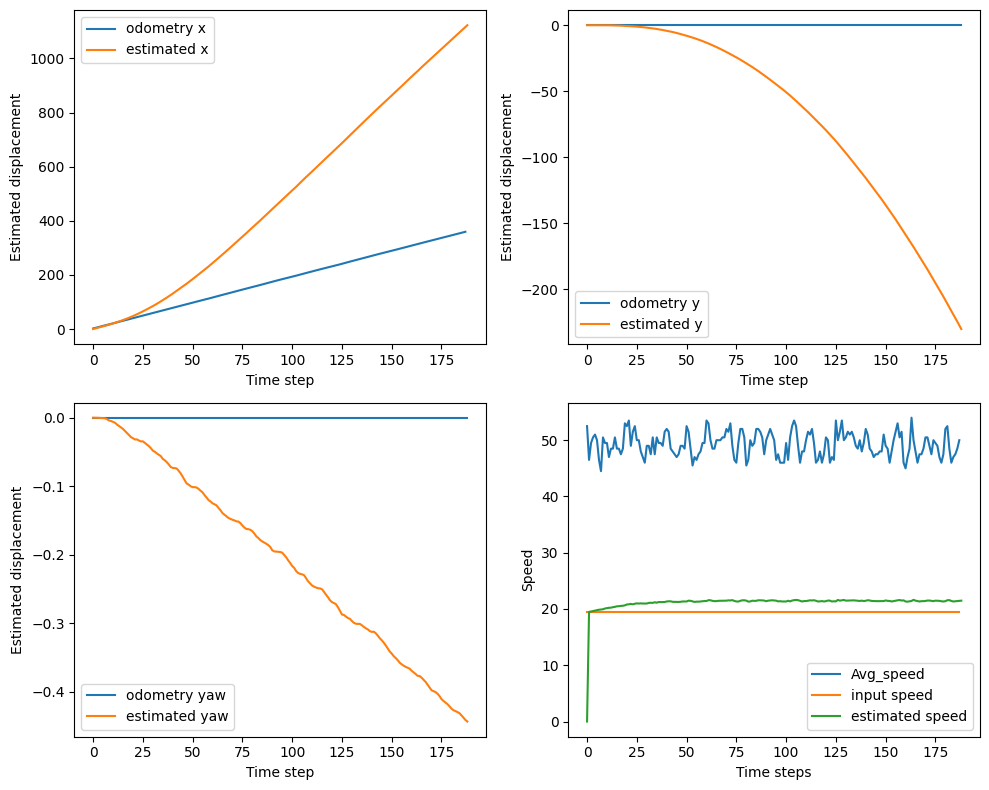

In [11]:
x_est = [[0,0,0,0,0]]
P_est = [np.zeros(5)]
pos_trans = 0

k0 = 55
L= 95 # distance between the 2 wheels in mm
thymio_speed_to_mms = 0.388 #value found in covariance_estimation

#odometry 
avg_speed = [(x["left_speed"]+x["right_speed"])/2 for x in thymio_data_stock_straight]
speed = [avg_speed[k0-1]]

difference_speed=[x["left_speed"]-x["right_speed"] for x in thymio_data_stock_straight]
omegas=np.array(difference_speed)*thymio_speed_to_mms/L #rad per second
omega=[omegas[k0-1]]

# control vect prev (meme tout le long ici)
l_speed=50
r_speed=50
avg_input_speed=(l_speed+r_speed)/2 * thymio_speed_to_mms
input_omega=(r_speed-l_speed)*thymio_speed_to_mms/L


camera_state=False


for k in tqdm(range(55, len(thymio_data_stock_straight))):
    speed.append(avg_speed[k])
    omega.append(omegas[k])
    obs_camera=[np.nan,np.nan,np.nan]
    obs_odometry=[speed[-1],omega[-1]]

    # control_vect=np.array([speed[-1],omega[-1]])
    control_vect=[avg_input_speed,input_omega]
    new_x_est, new_P_est = ekf(x_est[-1], control_vect, P_est[-1], obs_camera,obs_odometry, camera_state)
    x_est.append(new_x_est)
    P_est.append(new_P_est)

pos_increments_x = np.array(avg_speed[k0:])/(1/(thymio_speed_to_mms*Ts))
odom_pos_x= np.cumsum(pos_increments_x)

fig, axes=plt.subplots(2,2,figsize=(10, 8))
axes[0,0].plot([x for x in odom_pos_x], label="odometry x")
axes[0,0].plot([x[0] for x in x_est], label="estimated x")
axes[0,0].set_xlabel("Time step")
axes[0,0].set_ylabel("Estimated displacement")
axes[0,0].legend()

axes[0,1].plot(np.zeros(len(x_est)), label="odometry y")
axes[0,1].plot([x[1] for x in x_est], label="estimated y")
axes[0,1].set_xlabel("Time step")
axes[0,1].set_ylabel("Estimated displacement")
axes[0,1].legend()

axes[1,0].plot(np.zeros(len(x_est)), label="odometry yaw")
axes[1,0].plot([x[2] for x in x_est], label="estimated yaw")
axes[1,0].set_xlabel("Time step")
axes[1,0].set_ylabel("Estimated displacement")
axes[1,0].legend()

axes[1,1].plot([speed for speed in avg_speed[55:]], label="Avg_speed")
axes[1,1].plot(np.array([avg_input_speed]*len(avg_speed[55:])), label="input speed")
axes[1,1].plot([x[3] for x in x_est], label="estimated speed")
axes[1,1].set_xlabel("Time steps")
axes[1,1].set_ylabel("Speed")
axes[1,1].legend()

plt.tight_layout()
plt.show()

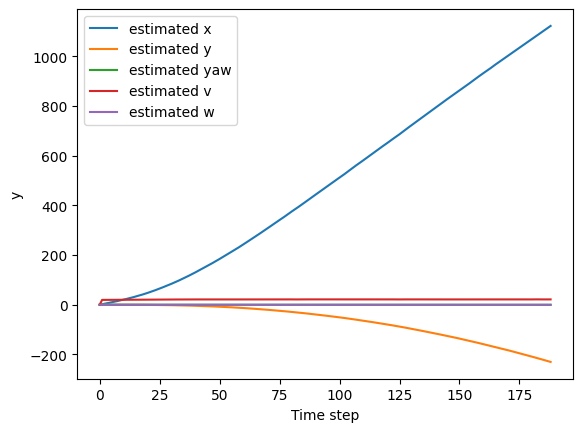

In [12]:
plt.plot([x[0] for x in x_est], label="estimated x")
plt.plot([x[1] for x in x_est], label="estimated y")
plt.plot([x[2] for x in x_est], label="estimated yaw")
plt.plot([x[3] for x in x_est], label="estimated v")
plt.plot([x[4] for x in x_est], label="estimated w")
plt.xlabel("Time step")
plt.ylabel("y")
plt.legend()

Sources: 
- https://automaticaddison.com/extended-kalman-filter-ekf-with-python-code-example/

- https://en.wikipedia.org/wiki/Extended_Kalman_filter#Discrete-time_predict_and_update_equations

- Cours du prof